In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
#
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
np.random.seed(1)

In [13]:
#
import numpy as np
# データ生成 --------------------------------
np.random.seed(seed=1)  # 乱数を固定
N = 200  # データの数
K = 3  # 分布の数
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]  # X0 の範囲 , 表示用
X_range1 = [-3, 3]  # X1 の範囲 , 表示用
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])  # 分布の中心
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]])  # 分布の分散
Pi = np.array([0.4, 0.8, 1])  # 各分布への割合
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]

In [14]:
#
# 2 分類のデータをテスト・訓練データに分割
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

# -------- データを 'class_data.npz' に保存
np.savez('class_data.npz', X_train=X_train, T_train=T_train, 
                           X_test=X_test, T_test=T_test,
                           X_range0=X_range0, X_range1=X_range1)

In [15]:
#
outfile = np.load('class_data.npz')

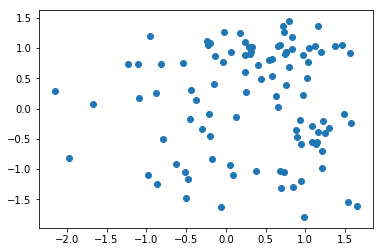

In [16]:
plt.scatter(X_train[:, 0], X_train[:, 1])

In [17]:
# データの図示 ------------------------------
# t[:, 1~3] == 1　のものだけx[True]として色付けして表示。なおinputは2次元入力、3分類出力。
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)

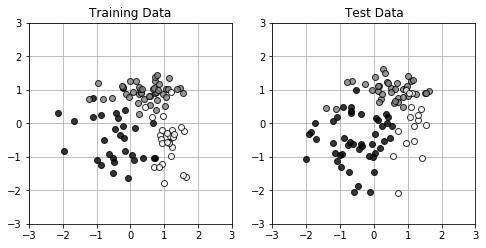

In [18]:
# メイン ------------------------------------
plt.figure(1, figsize=(8, 3.7))

plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')

plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [19]:
#
import keras.optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Activation

Using TensorFlow backend.
/Users/keisuke/.pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [20]:
#
model = Sequential()
model.add(Dense(2, input_dim=2, activation ='relu', kernel_initializer='uniform'))
model.add(Dense(3, activation='softmax', kernel_initializer='uniform'))
sgd = keras.optimizers.SGD(lr=0.5, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

modelにfitさせるときはX_trainは、（60000, 2）などの2次元、T_trainも(10000, 3)などの2次元でinputする。

In [21]:
#
startTime = time.time()
history = model.fit(X_train, T_train, epochs=1000, batch_size=100, verbose=0, 
                    validation_data=(X_test, T_test))

score = model.evaluate(X_test, T_test, verbose=0)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'.format(score[0], score[1]))
calculation_time = time.time() - startTime
print('Calculation time: {0:.3f} sec'.format(calculation_time))

cross entropy 0.27, accuracy 0.92
Calculation time: 1.844 sec


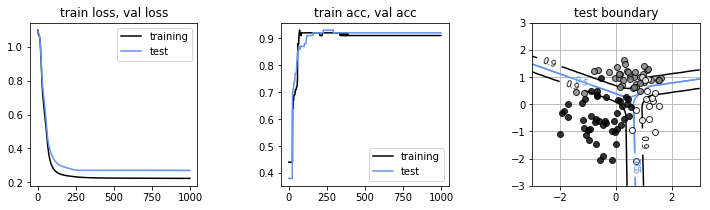

In [22]:
# リスト 7-2-(4)
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace=0.5)

# 学習曲線表示  --------------------------
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label='training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label='test') #(B)
plt.title('train loss, val loss')
plt.legend()

# 精度表示  --------------------------
plt.subplot(1, 3, 2)
plt.plot(history.history['acc'], 'black', label='training') # (C)
plt.plot(history.history['val_acc'], 'cornflowerblue', label='test') #(D)
plt.title('train acc, val acc')
plt.legend()

# 境界線表示  --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60  # 等高線表示の解像度
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y = model.predict(x) # (E)
K = 3
for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=[
                       'cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.title('test boundary')
plt.show()

In [23]:
#
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [27]:
x_train.shape

(60000, 28, 28)

In [26]:
img.shape

(28, 28)

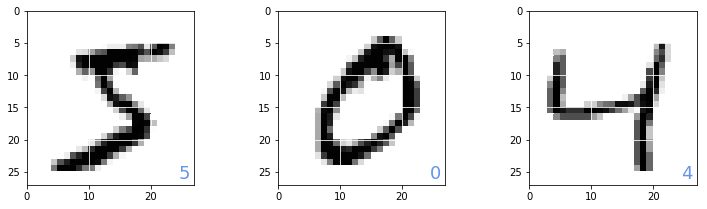

In [24]:
#
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.ﬁgure(1, ﬁgsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()
for id in range(3):
    plt.subplot(1, 3, id + 1)
    img = x_train[id, :, :]
    plt.pcolor(255 -img) #数値を色に変えてる
    plt.text(24.5, 26, "%d" % y_train[id], color='cornflowerblue', fontsize=18) # 右下のラベル表示
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.grid('on', color='white')
plt.show()

In [182]:
x_train.shape

(60000, 28, 28)

In [183]:
#
from keras.utils import np_utils

x_train = x_train.reshape(60000, 784)
x_train = x_train.astype('float32')
x_train = x_train/255
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes) #バイナリ変換（1-ofK符号化法）で60000*10に。

Edit x_test same as x_train

In [184]:
#
x_test = x_test.reshape(10000, 784)
x_test = x_test.astype('float32')
x_test = x_test/255
y_test = np_utils.to_categorical(y_test, num_classes)

784次元→16次元→10次元　に訓練

In [185]:
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(16, input_dim=784, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [186]:
import time

startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=1, 
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
print('Computation time:{0:3f} sec'.format(time.time() - startTime))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 19us/step - loss: 2.0629 - acc: 0.2878 - val_loss: 1.7871 - val_acc: 0.4991
Epoch 2/10
60000/60000 [==============================] - 1s 9us/step - loss: 1.6064 - acc: 0.6507 - val_loss: 1.4378 - val_acc: 0.7669
Epoch 3/10
60000/60000 [==============================] - 0s 8us/step - loss: 1.3198 - acc: 0.7880 - val_loss: 1.1986 - val_acc: 0.8198
Epoch 4/10
60000/60000 [==============================] - 0s 8us/step - loss: 1.1134 - acc: 0.8246 - val_loss: 1.0193 - val_acc: 0.8444
Epoch 5/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.9547 - acc: 0.8436 - val_loss: 0.8797 - val_acc: 0.8585
Epoch 6/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.8310 - acc: 0.8588 - val_loss: 0.7720 - val_acc: 0.8709
Epoch 7/10
60000/60000 [==============================] - 0s 7us/step - loss: 0.7358 - acc: 0.8691 - val_loss: 0.6884 - val_acc: 0.87

In [4]:
import numpy as np
np.nonzero(np.array([1,1,1,0,0,3,10]))

(array([0, 1, 2, 5, 6]),)

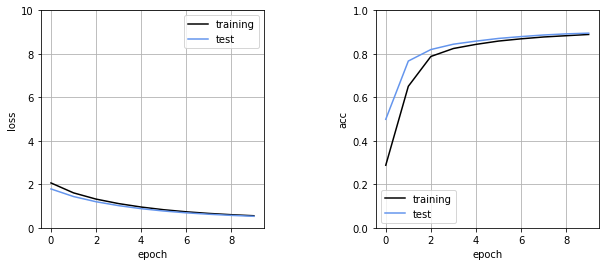

In [187]:
#
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.ﬁgure(1, ﬁgsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training', color='black')
plt.plot(history.history['val_loss'], label='test', 
color='cornflowerblue')
plt.ylim(0, 10)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='training', color='black')
plt.plot(history.history['val_acc'],label='test', color='cornflowerblue')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

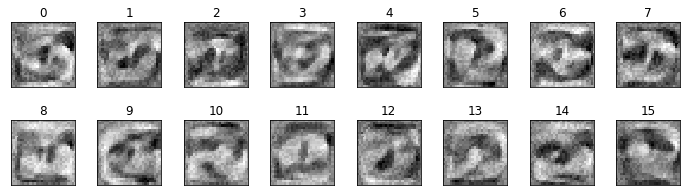

In [188]:
#
w = model.layers[0].get_weights()[0]
plt.figure(1, figsize=(12,3))
#plt.gray()
plt.subplots_adjust(wspace=0.35, hspace=0.5)
for i in range(16):
    plt.subplot(2,8, i+1)
    w1 = w[:, i]
    w1 = w1.reshape(28, 28)
    plt.pcolor(-w1)
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.xticks([], '')
    plt.yticks([], '')
    plt.title('%d' % i)
    #plt.title('{}'.format(i)) でも可能
plt.show()

In [191]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [202]:
#
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

(x_train ,y_train), (x_test, y_test) = mnist.load_data() #この地点では(60000,28,28)
x_train = x_train.reshape(60000, 28, 28, 1) # これで一番小さい要素もリストで括られることになる
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [207]:
#
import matplotlib.pyplot as plt
%matplotlib inline

id_img = 2
myﬁl1 = np.array([[1, 1, 1], 
                                 [1, 1, 1],
                                [-2, -2, -2]], dtype=ﬂoat)  # (A)
myﬁl2 = np.array([[-2, 1, 1], 
                                 [-2, 1, 1], 
                                 [-2, 1, 1]], dtype=ﬂoat)  # (B)

x_img = x_train[id_img, :, :, 0]
img_h = 28
img_w = 28
x_img = x_img.reshape(img_h, img_w)
out_img1 = np.zeros_like(x_img)
out_img2 = np.zeros_like(x_img)

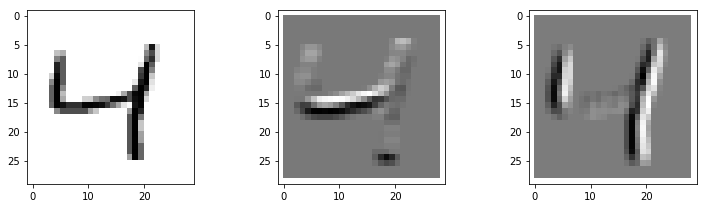

In [208]:
#
for ih in range(img_h - 3):
    for iw in range(img_w - 3):
        img_part = x_img[ih:ih + 3, iw:iw + 3]
        out_img1[ih + 1, iw + 1] = \
             np.dot(img_part.reshape(-1), myﬁl1.reshape(-1))
        out_img2[ih + 1, iw + 1] = \
             np.dot(img_part.reshape(-1), myﬁl2.reshape(-1))
            
#-- 表示
plt.ﬁgure(1, ﬁgsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()
plt.subplot(1, 3, 1)
plt.pcolor(1 - x_img)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.subplot(1, 3, 2)
plt.pcolor(-out_img1)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.subplot(1, 3, 3)
plt.pcolor(-out_img2)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.show()

In [209]:
#
import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
import time

In [30]:
#
model = Sequential()
model.add(Conv2D(8, (3,3), padding='same', input_shape=(28, 28, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

NameError: name 'Conv2D' is not defined

In [29]:
startTime = time.time()
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1, 
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('test loss: ', score[0])
print('test accuracy: ', score[1])
print('computation time: {0:.3f}sec'.format(time.time() - startTime))

ValueError: Error when checking input: expected dense_1_input to have 2 dimensions, but got array with shape (60000, 28, 28)

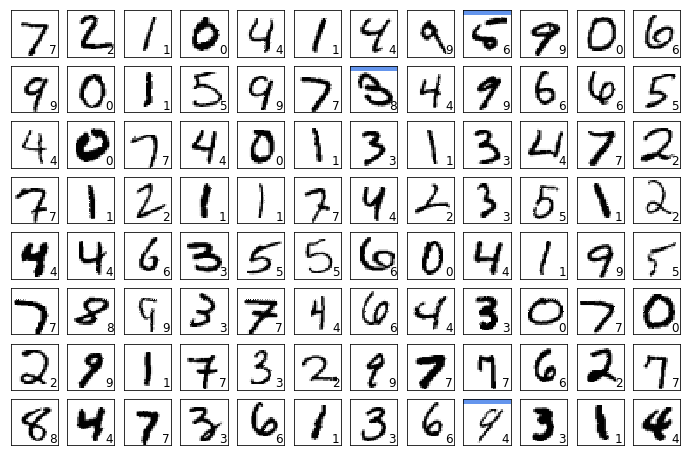

In [213]:
def show_prediction():
    n_show = 96
    y = model.predict(x_test)  # (A)
    plt.ﬁgure(2, ﬁgsize=(12, 8))
    plt.gray()
    for i in range(n_show):
        plt.subplot(8, 12, i + 1)
        x = x_test[i, :]
        x = x.reshape(28, 28)
        plt.pcolor(1 - x)
        wk = y[i, :]
        prediction = np.argmax(wk)
        plt.text(22, 25.5, "%d" % prediction, fontsize=12)
        if prediction != np.argmax(y_test[i, :]):
            plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], "")
        plt.yticks([], "")
show_prediction()
plt.show()

In [214]:
#
import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
import time

In [216]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))    #25%残している
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [221]:
startTime = time.time()
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1, 
                   validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', score[0])
print('test accuracy:', score[1])
print('computation time:{0:.3f} sec'.format(time.time() - startTime))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 71s 1ms/step - loss: 0.6260 - acc: 0.8071 - val_loss: 0.1163 - val_acc: 0.9646
Epoch 2/20
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1299 - acc: 0.9609 - val_loss: 0.0623 - val_acc: 0.9799
Epoch 3/20
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0858 - acc: 0.9741 - val_loss: 0.0467 - val_acc: 0.9857
Epoch 4/20
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0676 - acc: 0.9794 - val_loss: 0.0378 - val_acc: 0.9883
Epoch 5/20
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0558 - acc: 0.9831 - val_loss: 0.0312 - val_acc: 0.9895
Epoch 6/20
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0497 - acc: 0.9842 - val_loss: 0.0291 - val_acc: 0.9902
Epoch 7/20
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0460 - acc: 0.9854 - val_loss: 0.0286 - val_acc

In [6]:
print(1392/60, 'minutes')

23.2 minutes
